In [1]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

import argparse

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

from sklearn.model_selection import KFold # cross-validation용

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

2025-06-16 08:38:02.293849: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 08:38:02.347037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-16 08:38:03.119277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt

# faultD Loader
class FaultD_Loader(Dataset):
    def __init__(self, ts_file_path):
        self.data = []
        self.labels = []

        with open(ts_file_path, 'r') as f:
            lines = f.readlines()

        # @data 이후부터 유효한 데이터
        data_start_idx = next(i for i, line in enumerate(lines) if line.strip().lower() == "@data") + 1
        data_lines = [line.strip() for line in lines[data_start_idx:] if line.strip()]

        for line in data_lines:
            if ':' not in line:
                continue

            signal_str, label_str = line.rsplit(':', 1)
            signal = np.array([float(x) for x in signal_str.split(',')], dtype=np.float32)

            # 0~1 정규화 (데이터포인트 단위)
            min_val, max_val = np.min(signal), np.max(signal)
            if max_val - min_val > 0:
                signal = (signal - min_val) / (max_val - min_val)
            else:
                signal = np.zeros_like(signal)

            label = int(label_str.strip())

            self.data.append(torch.tensor(signal))  # shape: [5120]
            self.labels.append(label)               # int: 0, 1, 2

        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], idx


# 데이터셋 로드 (파일 경로는 직접 설정)
dataset = FaultD_Loader(ts_file_path='/home/hschoi/data/leehyunwon/time_series_FaultDetectionA/FaultDetectionA_TRAIN.ts')




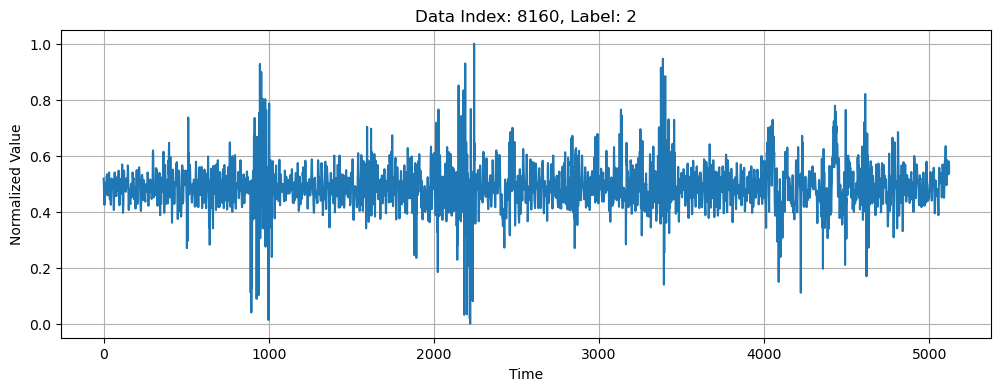

In [ ]:
# 보고 싶은 데이터 인덱스
# 혹시 몰라 적어둠 : -40 -60(좌하) : 1403 0번, 40 20(갈색) : 8889 1번, -20 20(하늘) : 8160 2번
idx = 8160

# 데이터 로드
signal, label, _ = dataset[idx]  # _는 idx 그대로 (필요 없으면 무시)

# 플롯 그리기
plt.figure(figsize=(12, 4))
plt.plot(signal.numpy())
plt.title(f'Data Index: {idx}, Label: {label}')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.savefig(f'temp.pdf')  # 임시저장
plt.show()